In [317]:
import joblib
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [318]:
##Uploading the data
df = pd.read_csv("dataset/loan_data.csv")
df.head(10)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


In [319]:
##Getting info about the data
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [321]:
df.shape

(45000, 14)

In [322]:
##Checking for nan
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

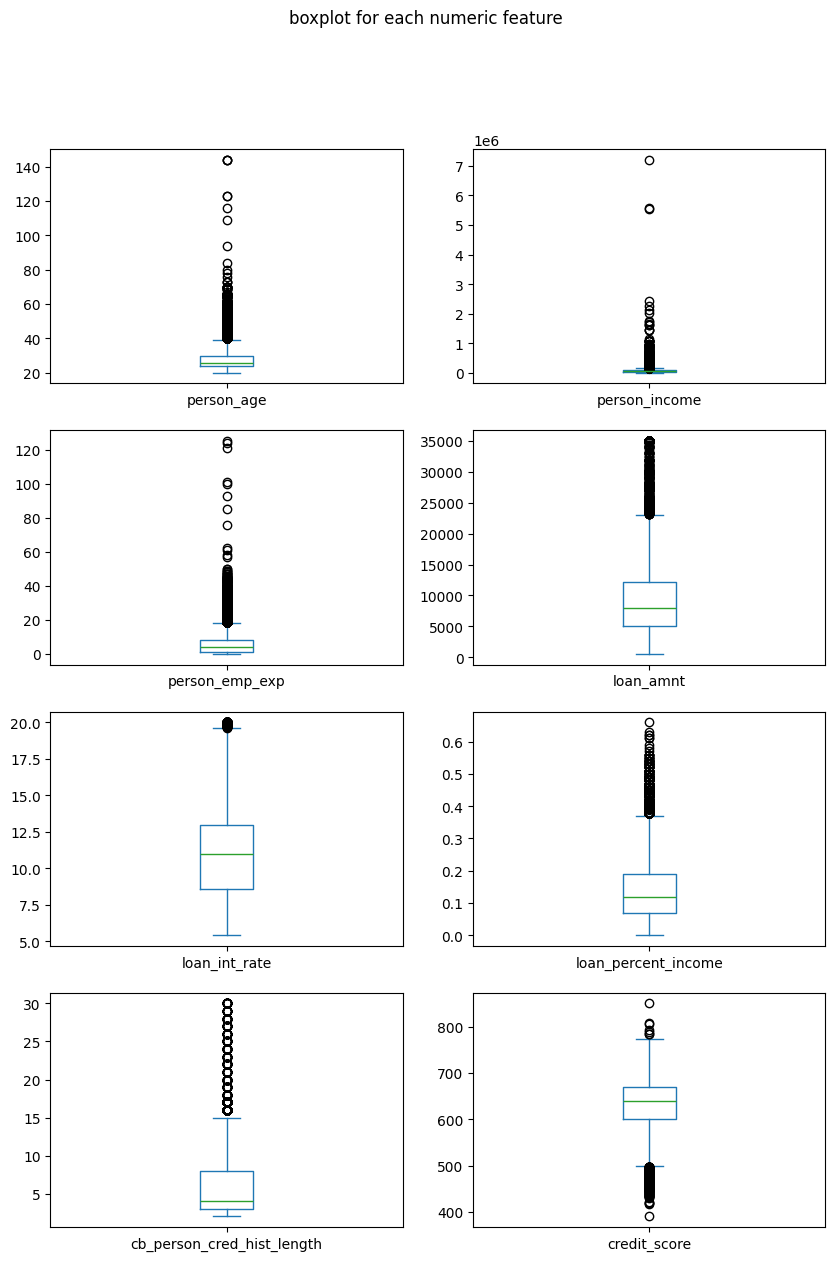

In [323]:
##Checking data for anomalies
df.select_dtypes(include=np.number).drop("loan_status", axis=1).plot(kind="box", subplots=True, layout=(4,2), figsize=(10,14), sharex=False, sharey=False, title="boxplot for each numeric feature")
plt.savefig("images/Boxplots.png", dpi=300)
plt.show()

Box plots show us that there are a lot of anomalies in person age and person experience columns. Need to fix it, because those feature are important for building future model(all columns having loan in name will be deleted so there is no ndeed to clean and normalize them)

In [324]:
##Counting true and false values in loan_status
df["loan_status"].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

As we can see data count isn't equal. False values are 3,5X times frequently met. Need to fix it, to make classification model more accurate

In [325]:
##Counting person age unique values and looking for anomalies
df["person_age"].value_counts(ascending=True)

person_age
78.0        1
84.0        1
80.0        1
94.0        1
109.0       1
116.0       1
67.0        1
76.0        1
123.0       2
144.0       3
63.0        3
73.0        3
69.0        5
59.0        6
70.0        7
62.0        7
64.0        7
65.0       10
66.0       11
61.0       12
60.0       16
57.0       17
20.0       17
58.0       20
56.0       20
54.0       24
55.0       24
53.0       35
52.0       42
51.0       46
50.0       56
49.0       59
48.0       93
47.0      112
46.0      114
45.0      135
44.0      177
43.0      215
42.0      247
41.0      303
40.0      349
39.0      389
38.0      503
37.0      666
36.0      740
35.0      847
34.0      980
33.0     1240
21.0     1289
32.0     1403
31.0     1645
30.0     2021
29.0     2455
28.0     2728
27.0     3095
26.0     3659
22.0     4236
25.0     4507
24.0     5138
23.0     5254
Name: count, dtype: int64

In [326]:
##Counting person employment experience unique values and looking for anomalies
df["person_emp_exp"].value_counts(ascending=True)

person_emp_exp
100       1
101       1
121       1
125       1
58        1
       ... 
4      3524
3      3890
1      4061
2      4134
0      9566
Name: count, Length: 63, dtype: int64

In [327]:
##Cleaning the data from bad data
df = df[(df["person_age"]<60) & (df["person_emp_exp"] < 40)]
df.shape

(44904, 14)

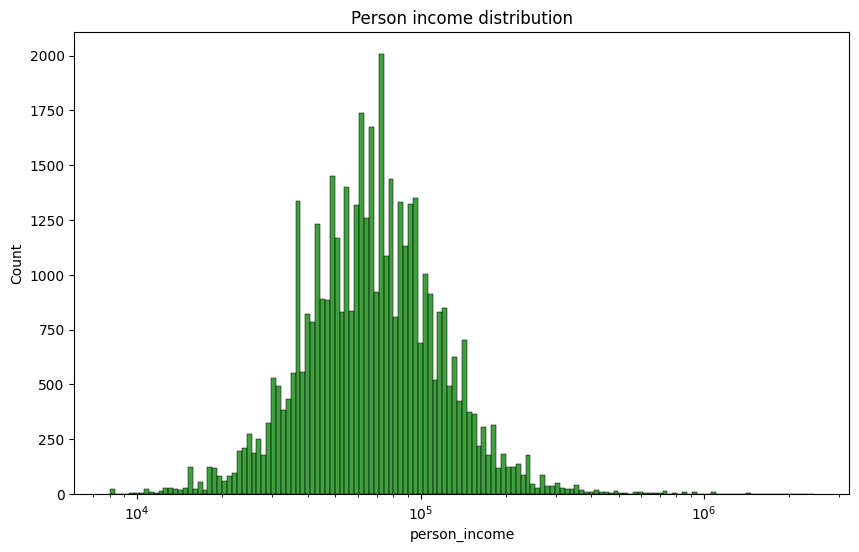

In [328]:
##Person income distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="person_income", log_scale=True, color="green")
plt.title("Person income distribution")
plt.savefig("images/Person_income.png")

Plot shows us that person income destribution is relative to a normal distribution

In [329]:
##Counting mean person income by gender
round(df.groupby("person_gender")[["person_income"]].mean(),2)

,person_income
person_gender,
female,78949.83
male,80457.35


According to the data male employees recieve a little bigger money than female employees

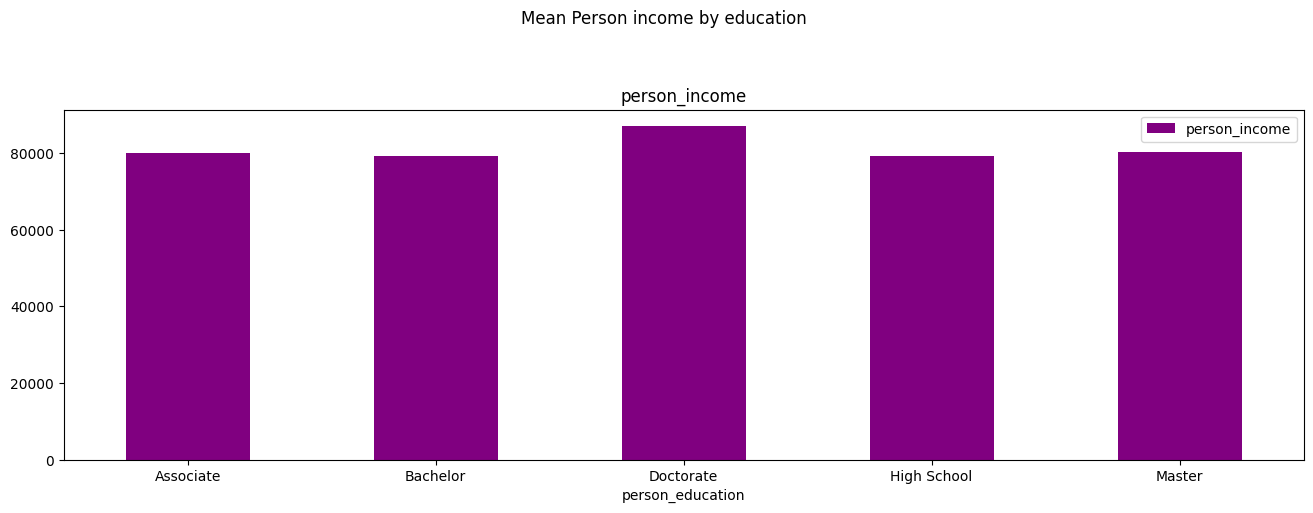

In [330]:
##Showing mean person income by education
df.groupby("person_education")[["person_income"]].mean().plot(kind="bar", rot= 0, subplots=True, layout=(2,1), figsize=(16,10), sharex=False, sharey=False, title="Mean Person income by education", color="purple")
plt.savefig("images/Income_by_education.png")

Data shows that mean person income is almost the same for all education degrees. So education degree doesn't effect on the income

In [331]:
##Choosing target value 
Y = df["loan_status"]
Y.shape

(44904,)

In [332]:
##Removing all unnecessary columns
columns = []
for x in df.columns:
    if "loan" in x.split("_"):
        columns.append(x)
columns

['loan_amnt',
 'loan_intent',
 'loan_int_rate',
 'loan_percent_income',
 'previous_loan_defaults_on_file',
 'loan_status']

In [333]:
##Starting making features
X_start = df.drop(columns, axis=1)
X_start

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,cb_person_cred_hist_length,credit_score
0,22.0,female,Master,71948.0,0,RENT,3.0,561
1,21.0,female,High School,12282.0,0,OWN,2.0,504
2,25.0,female,High School,12438.0,3,MORTGAGE,3.0,635
3,23.0,female,Bachelor,79753.0,0,RENT,2.0,675
4,24.0,male,Master,66135.0,1,RENT,4.0,586
...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,3.0,645
44996,37.0,female,Associate,65800.0,17,RENT,11.0,621
44997,33.0,male,Associate,56942.0,7,RENT,10.0,668
44998,29.0,male,Bachelor,33164.0,4,RENT,6.0,604


In [334]:
###Dividing feature data on numeric and categorical
X_numeric = X_start.select_dtypes(include=np.number)
X_numeric= X_numeric.reset_index(drop=True)
X_numeric

,person_age,person_income,person_emp_exp,cb_person_cred_hist_length,credit_score
0,22.0,71948.0,0,3.0,561
1,21.0,12282.0,0,2.0,504
2,25.0,12438.0,3,3.0,635
3,23.0,79753.0,0,2.0,675
4,24.0,66135.0,1,4.0,586
...,...,...,...,...,...
44899,27.0,47971.0,6,3.0,645
44900,37.0,65800.0,17,11.0,621
44901,33.0,56942.0,7,10.0,668
44902,29.0,33164.0,4,6.0,604


In [335]:
##Choosing categorical data
X_categorical = X_start.select_dtypes(include="object")
X_categorical.head()
X_categorical.shape

(44904, 3)

In [336]:
##Encoding categorical data
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X_categorical)
X_encoded.shape

(44904, 3)

In [337]:
##Checking results
X_cat = pd.DataFrame(X_encoded, columns=X_categorical.columns)
X_cat


,person_gender,person_education,person_home_ownership
0,0.0,4.0,3.0
1,0.0,3.0,2.0
2,0.0,3.0,0.0
3,0.0,1.0,3.0
4,1.0,4.0,3.0
...,...,...,...
44899,1.0,0.0,3.0
44900,0.0,0.0,3.0
44901,1.0,0.0,3.0
44902,1.0,1.0,3.0


In [338]:
###Uniting numeric and categorical features
X = pd.concat([X_cat, X_numeric], axis=1)
X

,person_gender,person_education,person_home_ownership,person_age,person_income,person_emp_exp,cb_person_cred_hist_length,credit_score
0,0.0,4.0,3.0,22.0,71948.0,0,3.0,561
1,0.0,3.0,2.0,21.0,12282.0,0,2.0,504
2,0.0,3.0,0.0,25.0,12438.0,3,3.0,635
3,0.0,1.0,3.0,23.0,79753.0,0,2.0,675
4,1.0,4.0,3.0,24.0,66135.0,1,4.0,586
...,...,...,...,...,...,...,...,...
44899,1.0,0.0,3.0,27.0,47971.0,6,3.0,645
44900,0.0,0.0,3.0,37.0,65800.0,17,11.0,621
44901,1.0,0.0,3.0,33.0,56942.0,7,10.0,668
44902,1.0,1.0,3.0,29.0,33164.0,4,6.0,604


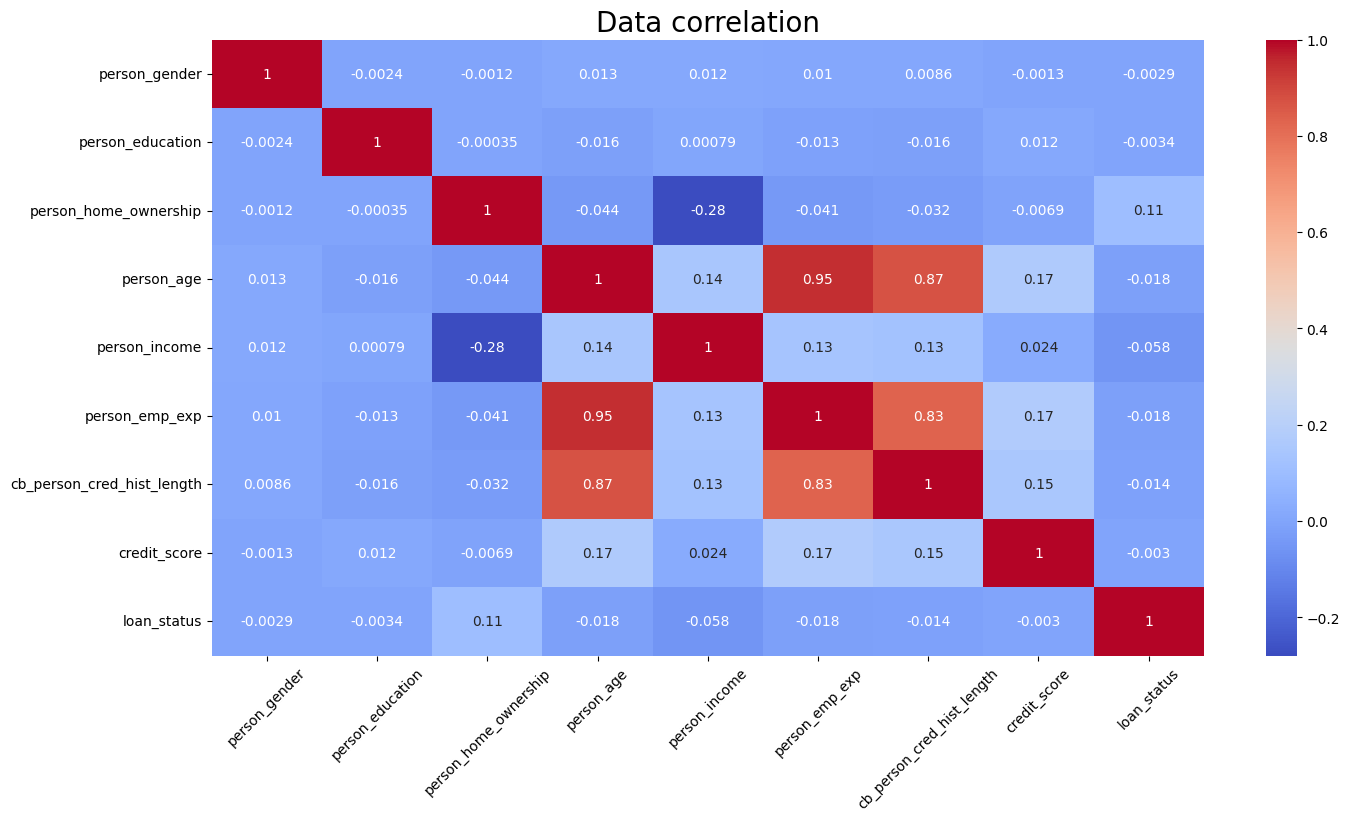

In [339]:
###Showing correlation between data
plt.figure(figsize=(16,8))
ax = sns.heatmap(pd.concat([X,Y],axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Data correlation", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("images/Data_correlation.png")
plt.show()

There is no even strong correlation between loan_status and other features

In [340]:
##Splitting data for training and for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [341]:
##Creating a smote model to equalize value counts 
smote = SMOTE(random_state=42)

In [342]:
##Emplementing smote resampling
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [343]:
##Creating XGBClassifier model
bst = XGBClassifier(n_estimators=4,  max_depth=6, learning_rate=1, objective='binary:logistic')

In [344]:
##Training the model
bst.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

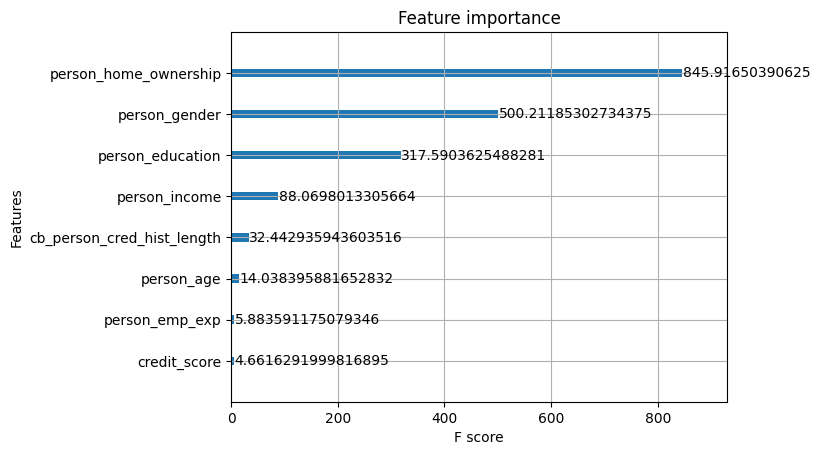

In [345]:
##Showing feature importance of the model
ax = plot_importance(bst, importance_type='gain', max_num_features=15)
ax.figure.savefig("images/XGB_feature_importance.png")

Person income, person education and person home ownership are three the most important features for this model. They're mostly used to make prediction

In [346]:
##Making predictions
preds = bst.predict(X_test)

In [347]:
##Showing accuracy
print(f"{accuracy_score(preds, Y_test):.2f}")

0.79


In [348]:
##Getting predict probability for a ROC curve
y_predict = bst.predict_proba(X_test)[:, 1]

In [349]:
# Getting data for ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, y_predict)
roc_auc = auc(fpr, tpr)
xgb_auc = roc_auc

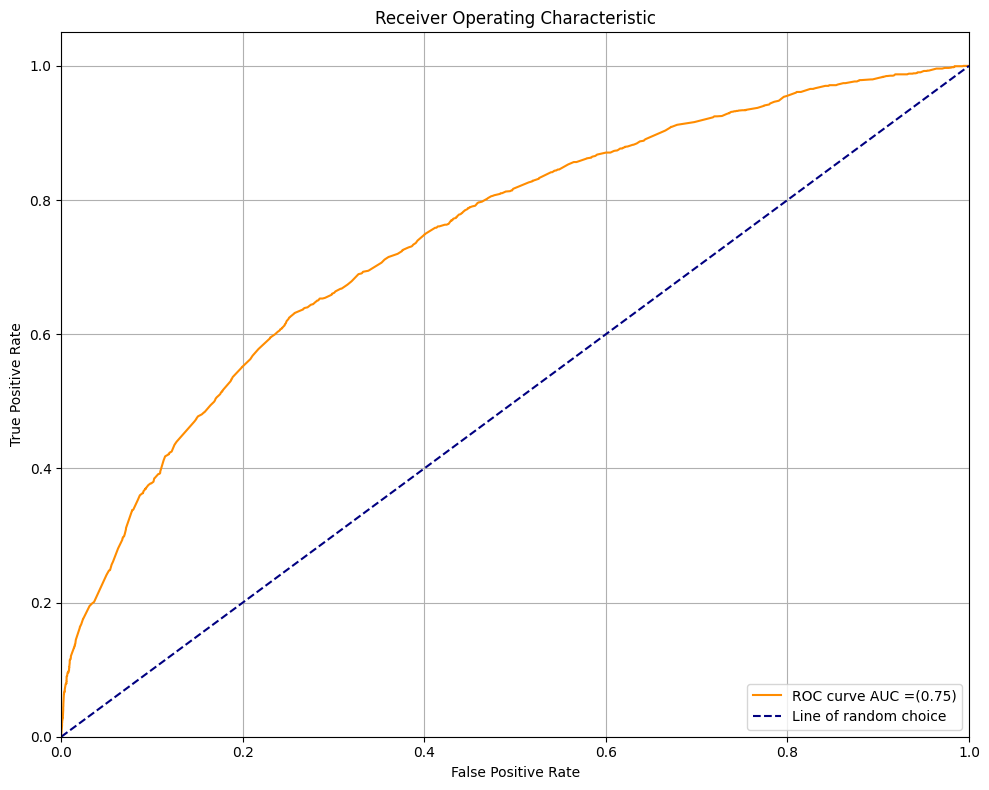

In [350]:
##ROC-curve for XGB model
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr, color="darkorange", label= f"ROC curve AUC =({roc_auc:.2f})")
plt.plot([0,1], [0,1], color='navy', linestyle="--", label=f"Line of random choice")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig("images/XGB_ROC_plot.png")
plt.show()

AUC equals 0.75, this is the mean result. Model isn't showing the best performance but the result is better than simple random guessing

In [351]:
##Creating Random Forest Classifier to compare models
clf = RandomForestClassifier(n_estimators=4, max_depth=5, max_features=15)

In [352]:
##Training the model
clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, max_features=15, n_estimators=4)

In [353]:
##Making prediction
pred1 = clf.predict(X_test)

In [354]:
##Showing accuracy
print(f"{accuracy_score(pred1, Y_test):.2f}")

0.78


Accuracy score of a tree model is 0.01 less. There is no difference between model performances

In [355]:
##Getting data for a feature importance plot
importances = clf.feature_importances_
feature_names = X.columns
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)


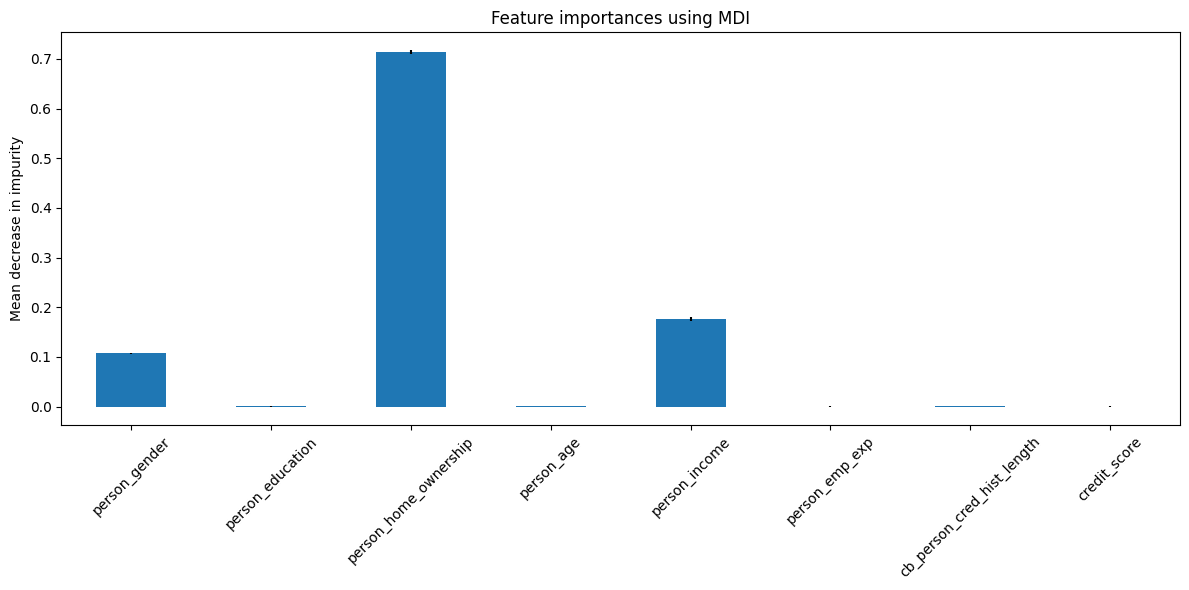

In [356]:
##Showing feature importance of a Tree Classifier
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=45)
plt.savefig("images/TREE_CLASSIFIER_feature_importance.png")
fig.tight_layout()

Person home ownership is the most important of used in tree classifier features for this model

In [357]:
##Getting predict probability for a ROC curve
y_predict = clf.predict_proba(X_test)[:, 1]

In [358]:
## Getting data for ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, y_predict)
roc_auc = auc(fpr, tpr)
rf_auc = roc_auc

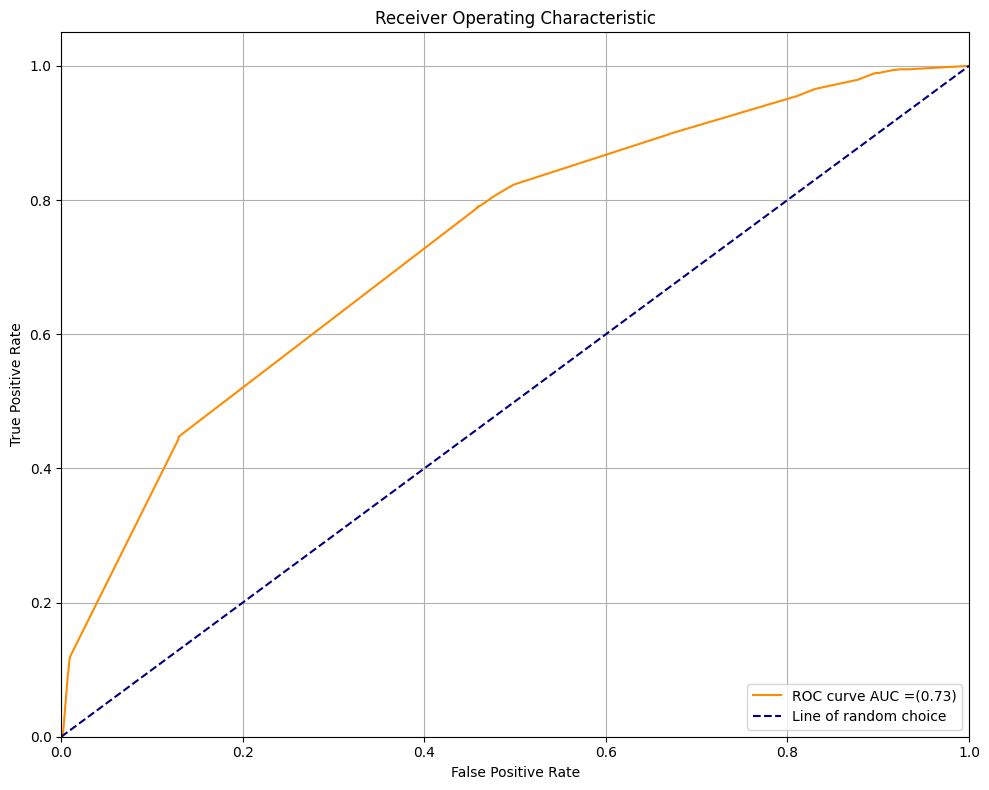

In [359]:
##ROC-curve for Tree Classifier model
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr, color="darkorange", label= f"ROC curve AUC =({roc_auc:.2f})")
plt.plot([0,1], [0,1], color='navy', linestyle="--", label=f"Line of random choice")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig("images/TREE_CLASSIFIER_ROC_plot.png")
plt.show()

AUC value of tree classifier model is smaller than XGB AUC value on 0.02 . It's not critical difference. Models are showing the same performance 

In [360]:
##Model conclusions
print("XGB AUC:", xgb_auc)
print("RF AUC:", rf_auc)

if xgb_auc > rf_auc:
    print("XGBoost performed better and was selected as the final model.")
else:
    print("RandomForest performed better and was selected.")

XGB AUC: 0.745533713131896
RF AUC: 0.7343824186918584
XGBoost performed better and was selected as the final model.


In [361]:
##Saving the better model
bst.save_model("XGB_model.bin")

C:\Users\ylokt\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [362]:
##Saving encoder
joblib.dump(encoder, "ordinal_encoder.pkl")

['ordinal_encoder.pkl']